In [56]:
import os
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [57]:
df = pd.read_csv("bank-full.csv", sep=";")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [58]:
df["y"] = df["y"].map({"yes": 1, "no": 0})

print(df["y"].value_counts())

y
0    39922
1     5289
Name: count, dtype: int64


In [59]:
df = pd.get_dummies(df, drop_first=True)

print("After encoding:", df.shape)
df.head()


After encoding: (45211, 43)


,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,29,5,151,1,-1,0,0,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,5,76,1,-1,0,0,False,True,...,False,False,False,True,False,False,False,False,False,True
3,47,1506,5,92,1,-1,0,0,True,False,...,False,False,False,True,False,False,False,False,False,True
4,33,1,5,198,1,-1,0,0,False,False,...,False,False,False,True,False,False,False,False,False,True


In [60]:
X = df.drop("y", axis=1)
y = df["y"]

feature_columns = X.columns

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])


Training Samples: 36168
Testing Samples: 9043


In [62]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [63]:
def evaluate_model(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred)
    }


In [64]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42
    )
}


In [65]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = evaluate_model(y_test, y_pred, y_prob)
    metrics["Model"] = name
    results.append(metrics)

    joblib.dump(model, f"model/{name.replace(' ', '_')}.pkl")


Training Logistic Regression...
Training Decision Tree...
Training KNN...
Training Naive Bayes...
Training Random Forest...
Training XGBoost...


In [66]:
metrics_df = pd.DataFrame(results)

metrics_df


,Accuracy,AUC,Precision,Recall,F1,MCC,Model
0,0.901250,0.905443,0.643979,0.348771,0.452483,0.426446,Logistic Regression
1,0.877695,0.713460,0.478261,0.499055,0.488437,0.419140,Decision Tree
2,0.893619,0.808369,0.586022,0.309074,0.404703,0.374213,KNN
3,0.863873,0.808813,0.428216,0.487713,0.456032,0.379655,Naive Bayes
4,0.905783,0.929282,0.664537,0.393195,0.494062,0.464576,Random Forest
5,0.907995,0.929058,0.634845,0.502836,0.561181,0.514894,XGBoost


In [67]:
metrics_df.to_csv("model/metrics.csv", index=False)
joblib.dump(scaler, "model/scaler.pkl")
joblib.dump(feature_columns, "model/feature_columns.pkl")

['model/feature_columns.pkl']

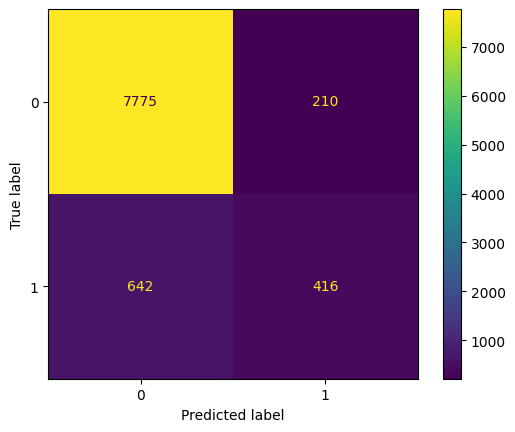

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf_model = models["Random Forest"]
y_pred_rf = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.show()
